# First Exploration of Auxtel Rehearsal

- author : Sylvie Dagoret-Campagne
- creation date :  2024-04-11
- update : 2024-04-11
- w_2024_10

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

### Schema for data sim
- https://dm.lsst.org/sdm_schemas/browser/imsim.html

In [1]:
from lsst.daf.butler import Butler
import lsst
from lsst.geom import Angle 
import pandas as pd
import numpy as np
repo = '/repo/embargo'
instrument = 'LATISS'
where_clause = "instrument = \'" + f"{instrument}" +"\'"
skymap_name = "latiss_v1"
collection0 = 'LSSTComCamSim/quickLook/24'
collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
#collection4 = 'LSSTComCamSim/runs/nightlyvalidation/20240405/d_2024_03_29/DM-43612'
#collection = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collection = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collections = [collection1,collection2]
#collections = [collection0,collection1,collection2,collection3]
# in collection1,collection3 no ccdVisitTable
collections = [collection]
butler = Butler(repo, collections=collections)
registry = butler.registry
from collections import OrderedDict

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch
# Astropy
from astropy.visualization import ZScaleInterval, AsinhStretch

import seaborn as sns
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd


#xx-small
#x-small
#small
#medium
#large
#x-large
#xx-large

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [3]:
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import coordinates
import astropy.coordinates as coord
import astropy.units as u

In [4]:
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collections).any(execute=False, exact=False):
        # Limit search results to the data products
        if ('_config' not in datasetType.name) and ('_log' not in datasetType.name) and ('_metadata' not in datasetType.name) and ('_resource_usage' not in datasetType.name):
            print(datasetType)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog)
DatasetType('skyMap', {skymap}, SkyMap)
DatasetType('atlas_refcat2_20220201', {htm7}, SimpleCatalog)
DatasetType('packages', {}, Packages)
DatasetType('icSrc_schema', {}, SourceCatalog)
DatasetType('src_schema', {}, SourceCatalog)
DatasetType('icSrc', {band, instrument, detector, physical_filter, visit}, SourceCatalog)
DatasetType('icExpBackground', {band, instrument, detector, physical_filter, visit}, Background)
DatasetType('icExp', {band, instrument, detector, ph

## How do I figure out which tracts have data?

In [5]:
for dtype in sorted(registry.queryDatasetTypes(expression="*nImage*")):
    print(dtype.name)

deepCoadd_nImage
goodSeeingCoadd_nImage


In [6]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [7]:
tracts = np.unique([ref.dataId['tract'] for ref in nImage_refs])
print(tracts)

bands = np.unique([ref.dataId['band'] for ref in nImage_refs])
print(bands)

[3864 5614 5615 5634]
['g' 'i' 'r' 'y' 'z']


In [8]:
tract_sel = tracts[0]

In [9]:
dict_tract_to_coords_deg = OrderedDict()
dict_tract_to_coords_rad = OrderedDict()
skymap = butler.get('skyMap', skymap=skymap_name)
for tract_sel in tracts:
    the_tract = skymap.generateTract(tract_sel)
    sp2 = the_tract.getCtrCoord() # get a SpherePoint(278.7804878048781*degrees, -48.34710743801652*degrees)
    dict_tract_to_coords_deg[tract_sel] = sp2
    dict_tract_to_coords_rad[tract_sel] = dict(ra = sp2[0].asRadians(), dec = sp2[1].asRadians() )

In [10]:
#for key, value in dict_tract_To_Coords.items():
#    print(key, "->", value,  " <=> (", value[0].asRadians()," , ", value[1].asRadians(), ")")

In [11]:
dict_tract_to_coords_deg 

OrderedDict([(3864,
              SpherePoint(122.43654822335026*degrees, -36.446280991735534*degrees)),
             (5614,
              SpherePoint(238.37837837837841*degrees, -24.545454545454543*degrees)),
             (5615,
              SpherePoint(239.99999999999997*degrees, -24.545454545454543*degrees)),
             (5634,
              SpherePoint(270.8108108108108*degrees, -24.545454545454543*degrees))])

In [12]:
dict_tract_to_coords_rad

OrderedDict([(3864, {'ra': 2.1369208912742756, 'dec': -0.6361076034128094}),
             (5614, {'ra': 4.160487568267564, 'dec': -0.42839899821678995}),
             (5615, {'ra': 4.1887902047863905, 'dec': -0.42839899821678995}),
             (5634, {'ra': 4.726540298644103, 'dec': -0.42839899821678995})])

In [13]:
# Check which tracts actually have a lot of visit coverage:
dict_tract_to_coords_andvisits = OrderedDict()
for tract_sel in tracts:
    visits = list(butler.registry.queryDatasets('visitSummary', tract=tract_sel, skymap=skymap_name, findFirst=True))
    Nvis = len(visits)
    dict_tract_to_coords_andvisits[tract_sel] = dict(ra_deg=dict_tract_to_coords_deg[tract_sel][0], dec_deg =dict_tract_to_coords_deg[tract_sel][1] , 
                                                     ra_rad = dict_tract_to_coords_rad[tract_sel]["ra"], dec_rad = dict_tract_to_coords_rad[tract_sel]["dec"],nvis=Nvis)
    

In [14]:
dict_tract_to_coords_andvisits

OrderedDict([(3864,
              {'ra_deg': Angle(122.43654822335026, degrees),
               'dec_deg': Angle(-36.446280991735534, degrees),
               'ra_rad': 2.1369208912742756,
               'dec_rad': -0.6361076034128094,
               'nvis': 2680}),
             (5614,
              {'ra_deg': Angle(238.37837837837841, degrees),
               'dec_deg': Angle(-24.545454545454543, degrees),
               'ra_rad': 4.160487568267564,
               'dec_rad': -0.42839899821678995,
               'nvis': 200}),
             (5615,
              {'ra_deg': Angle(239.99999999999997, degrees),
               'dec_deg': Angle(-24.545454545454543, degrees),
               'ra_rad': 4.1887902047863905,
               'dec_rad': -0.42839899821678995,
               'nvis': 692}),
             (5634,
              {'ra_deg': Angle(270.81081081081078, degrees),
               'dec_deg': Angle(-24.545454545454543, degrees),
               'ra_rad': 4.726540298644103,
            

## visitSummary

In [15]:
if 0:

    all_data = []
    data_product = 'visitSummary'

    #datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= "instrument='LSSTComCamSim'")
    datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where = where_clause)
    for i, ref in enumerate(datasetRefs):
        if (i % 100 == 0):
            print(f"======================== datasetType = {data_product} ============================================")
            print("fullId..................:",ref.dataId.full)
        try:
            data = butler.get(data_product, dataId=ref.dataId )  
            all_data.append(data)
       
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)         

    N = len(all_data)
    print(f"{visitSummary} :: N = {N}")

### CCD VisitTable

In [16]:
list(butler.registry.queryDatasets('ccdVisitTable'))

[DatasetRef(DatasetType('ccdVisitTable', {instrument}, DataFrame), {instrument: 'LATISS'}, run='LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240318T233836Z', id=a668b4fc-1320-43e7-a5b0-8eec62ad1c67)]

In [17]:
ccdVisitTable = butler.get('ccdVisitTable')

In [18]:
ccdVisitTable.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'effTime',
       'effTimePsfSigmaScale', 'effTimeSkyBgScale', 'effTimeZeroPointScale',
       'decl', 'detector', 'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD',
       'expTime', 'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize',
       'llcra', 'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra',
       'lrcdec'],
      dtype='object')

In [19]:
# https://pipelines.lsst.io/modules/lsst.geom/getting-started.html
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_zendtoAirmass = lambda x : 1./np.cos(func_degToRad(x))
#func_wrap = lambda x : Angle(x,lsst.geom.radians).wrap(180.*lsst.geom.degrees)

In [20]:
ccdVisitTable["airmass"] = ccdVisitTable['zenithDistance'].apply(func_zendtoAirmass)

Text(0, 0.5, 'zeroPoint')

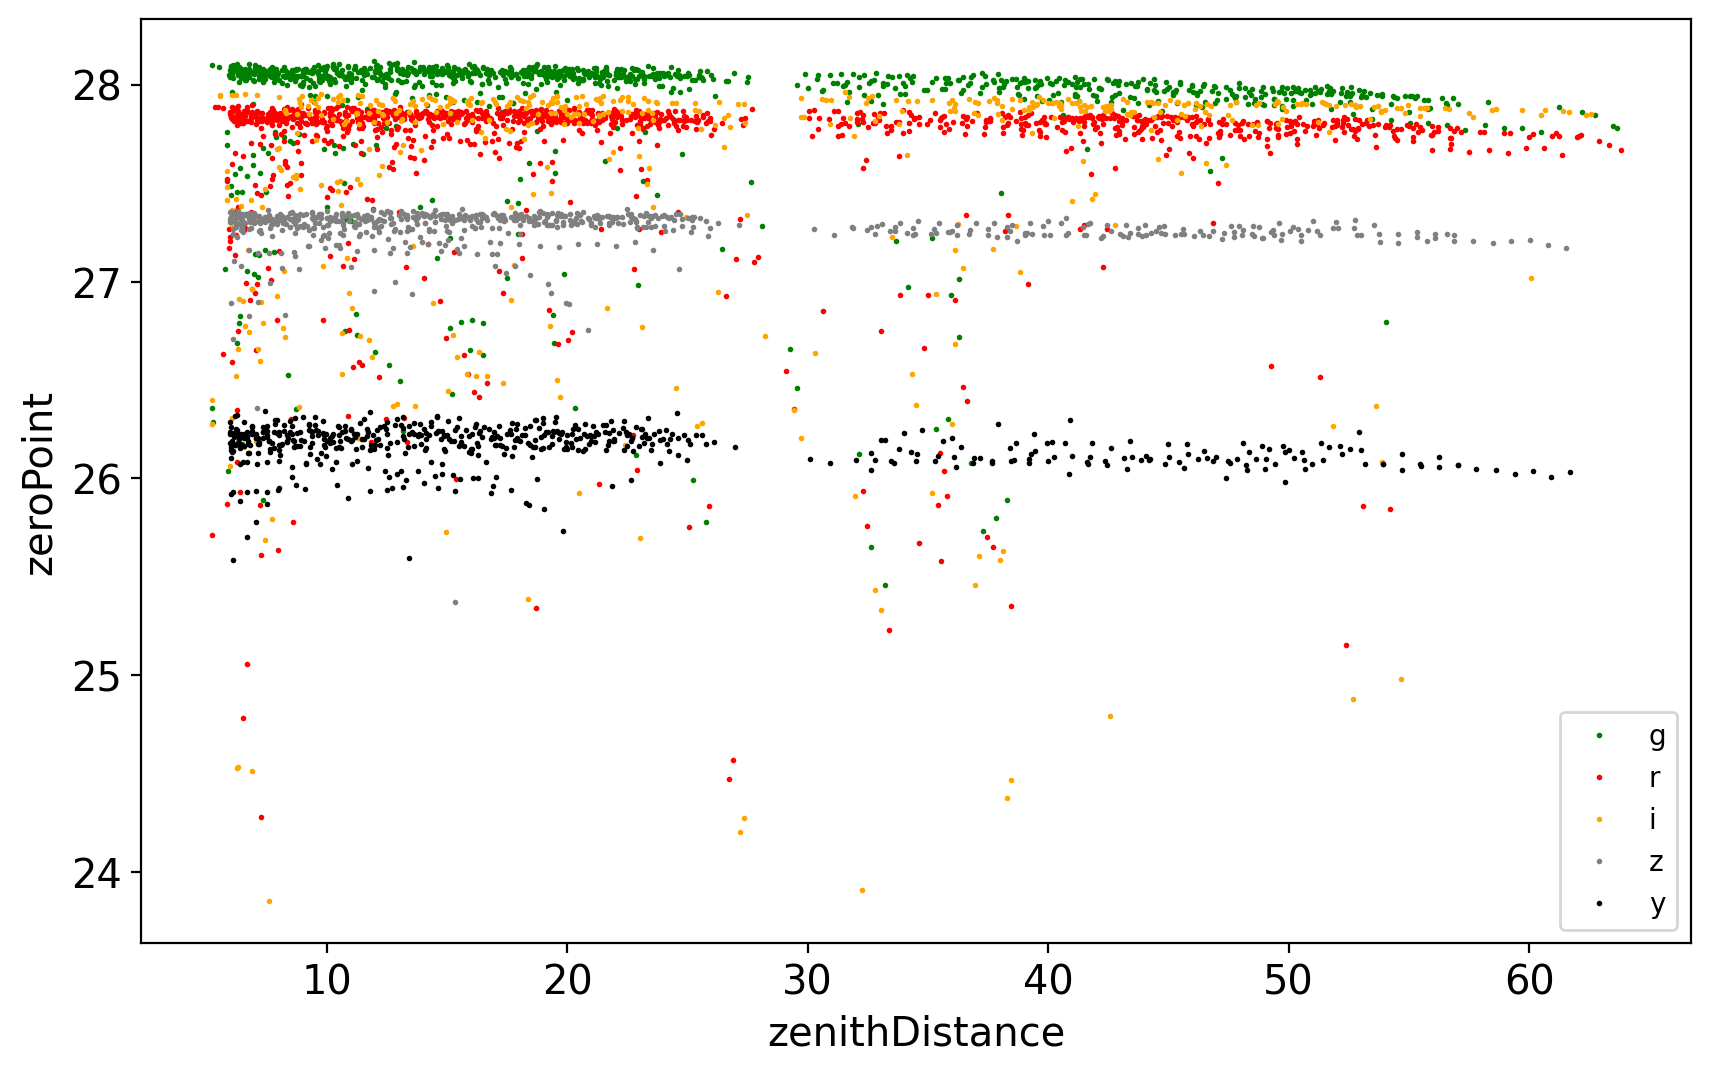

In [21]:
f2c = {'u': 'blue', 'g': 'green', 'r': 'red',
       'i': 'orange', 'z': 'grey', 'y': 'k'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['zenithDistance'][in_band], ccdVisitTable['zeroPoint'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('zenithDistance')
plt.ylabel('zeroPoint')

Text(0, 0.5, 'zeroPoint')

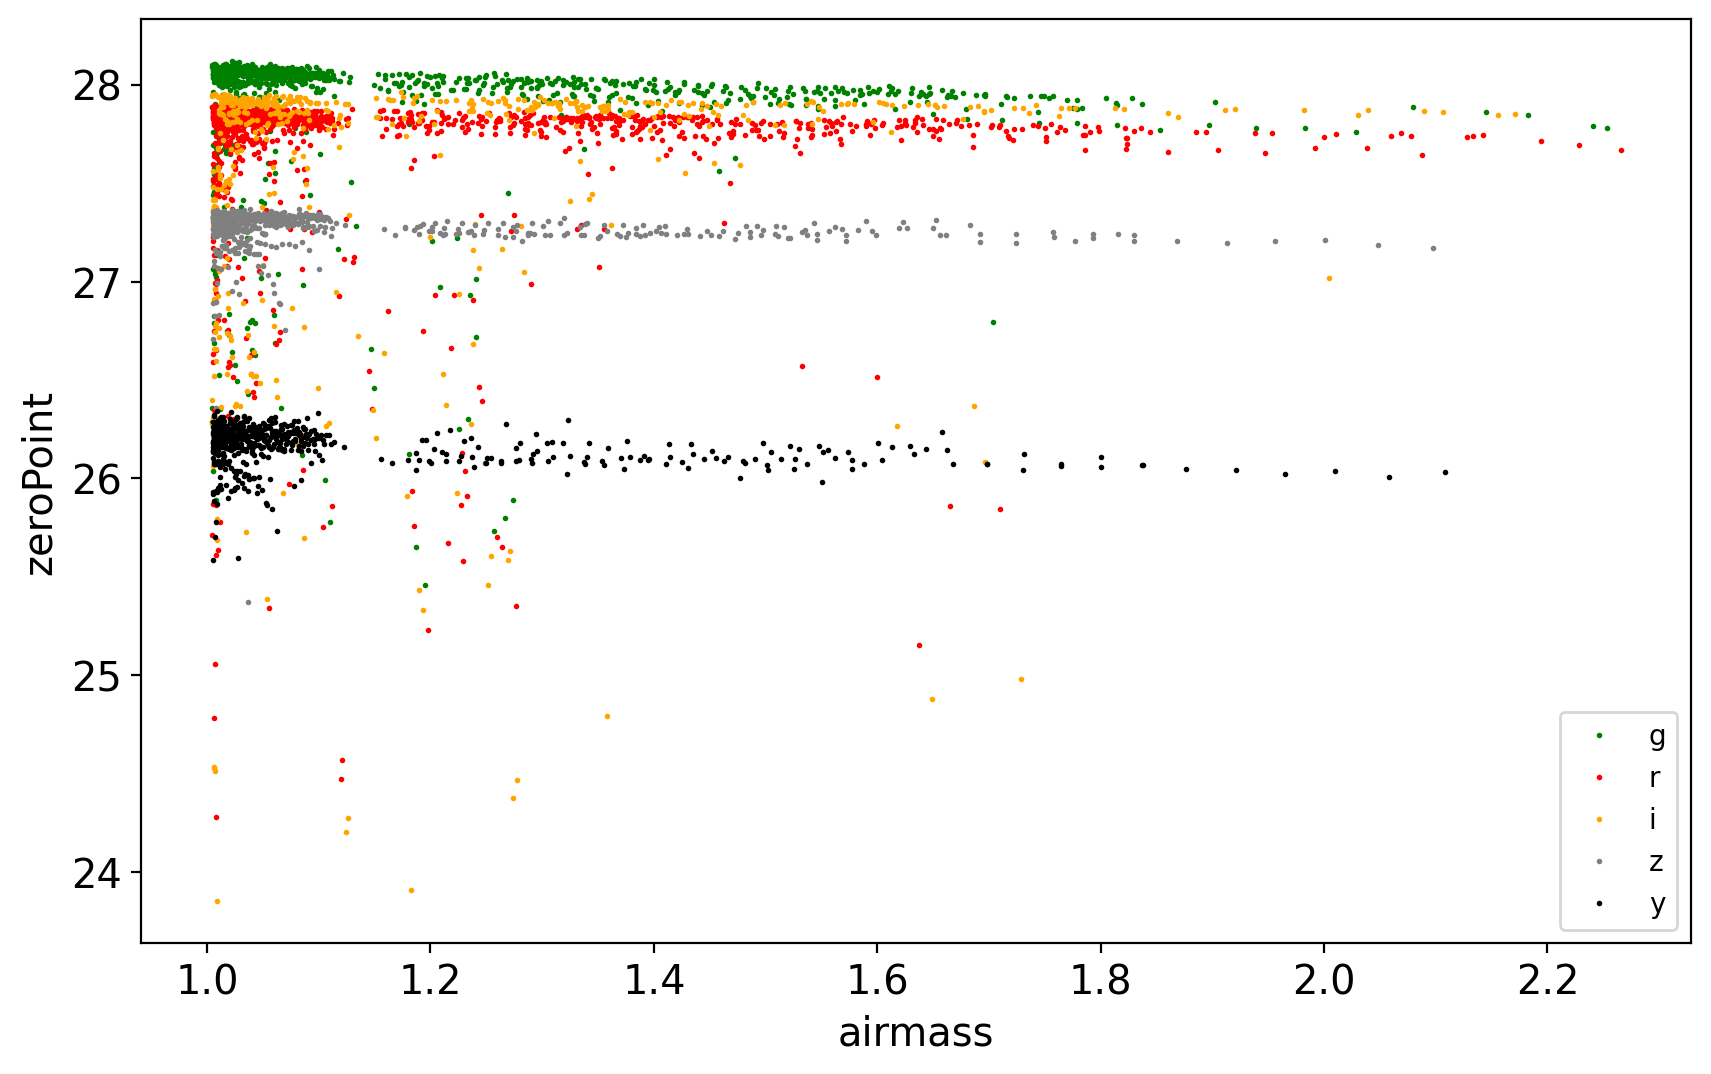

In [22]:
f2c = {'u': 'blue', 'g': 'green', 'r': 'red',
       'i': 'orange', 'z': 'grey', 'y': 'k'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['airmass'][in_band], ccdVisitTable['zeroPoint'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('airmass')
plt.ylabel('zeroPoint')

Text(0, 0.5, 'psfSigma')

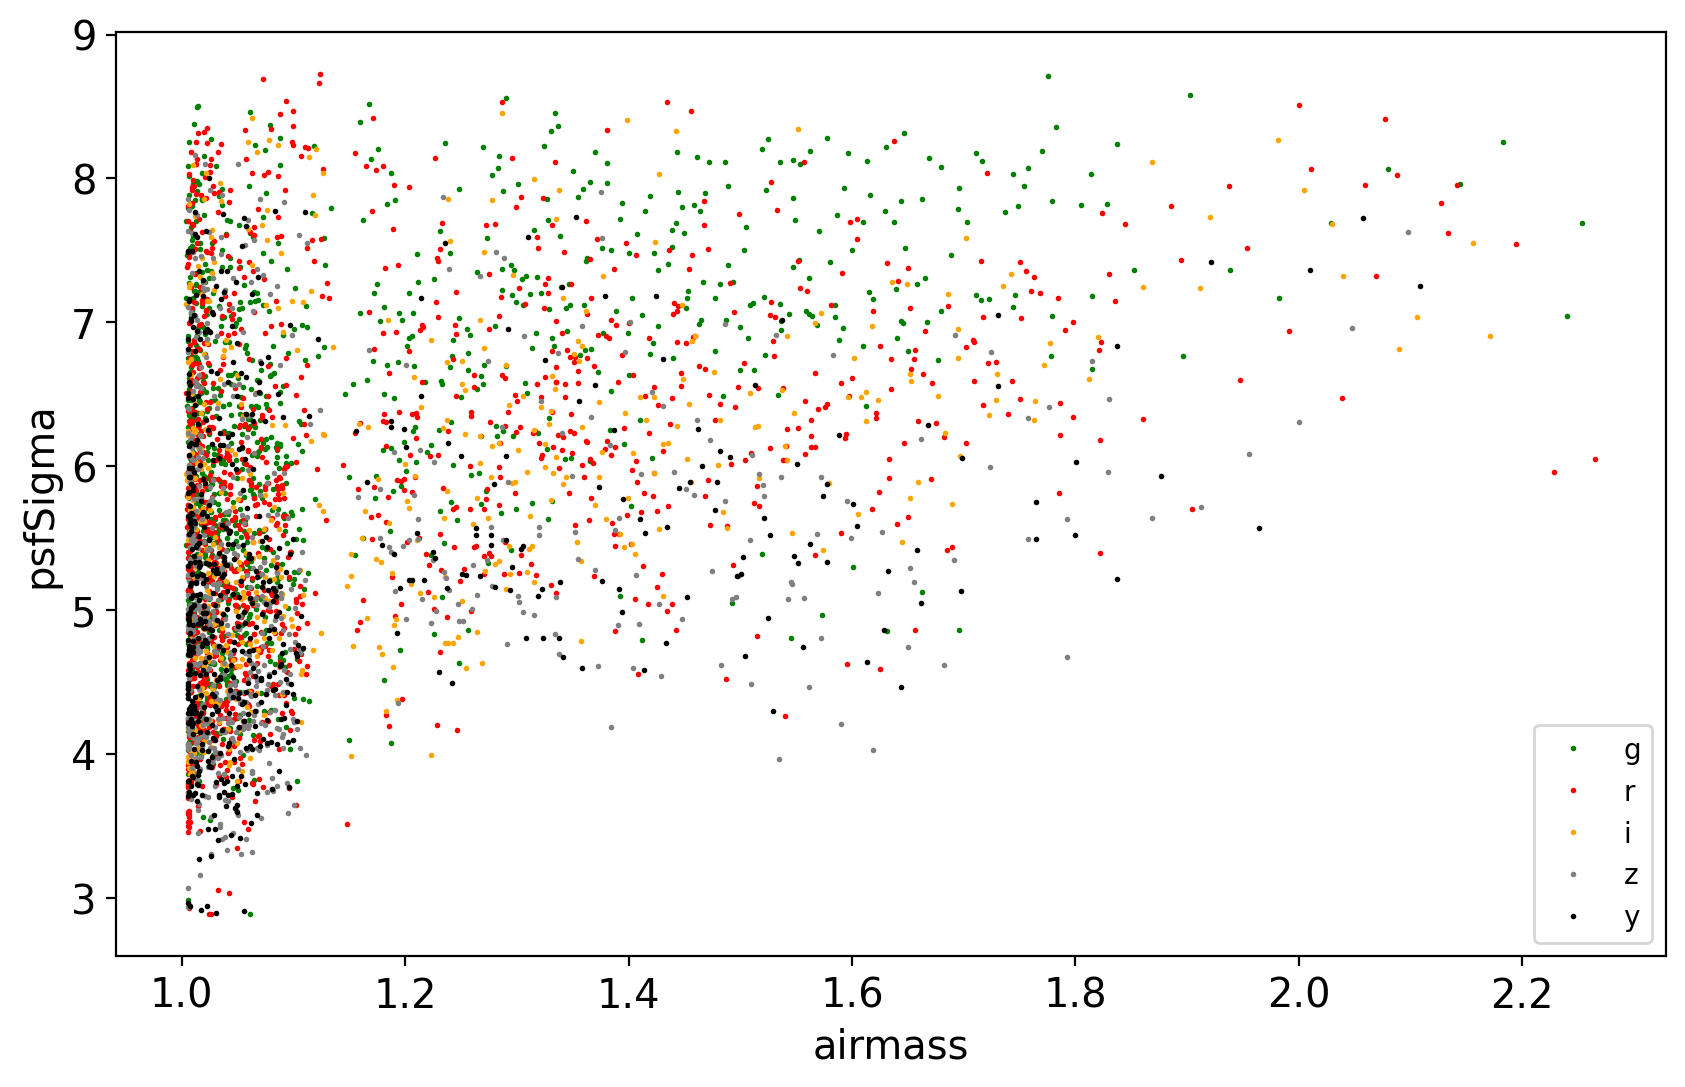

In [23]:
f2c = {'u': 'blue', 'g': 'green', 'r': 'red',
       'i': 'orange', 'z': 'grey', 'y': 'k'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['airmass'][in_band], ccdVisitTable['psfSigma'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('airmass')
plt.ylabel('psfSigma')

Text(0, 0.5, 'seeing')

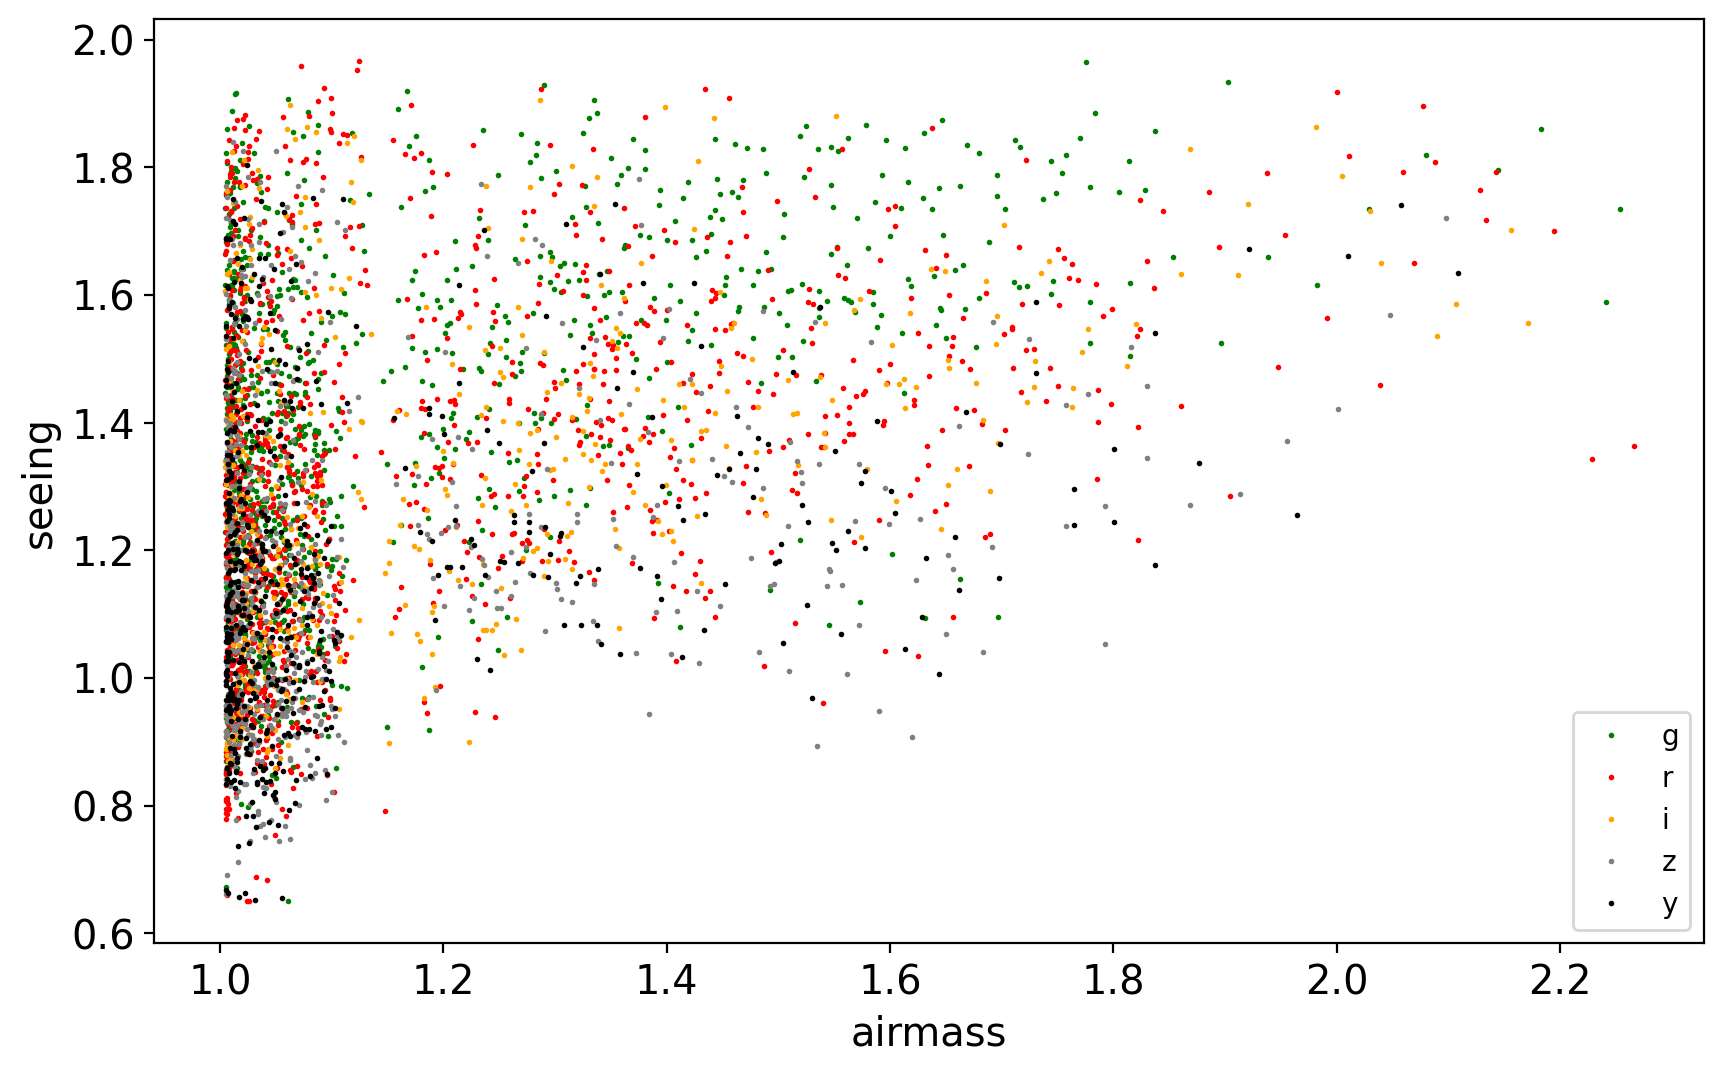

In [24]:
f2c = {'u': 'blue', 'g': 'green', 'r': 'red',
       'i': 'orange', 'z': 'grey', 'y': 'k'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['airmass'][in_band], ccdVisitTable['seeing'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('airmass')
plt.ylabel('seeing')

In [25]:
ccdvisit_subset = ccdVisitTable[['visitId', 'band', 'ra', 'dec','detector','zenithDistance','obsStartMJD']]

In [26]:
ccdvisit_subset 

,visitId,band,ra,dec,detector,zenithDistance,obsStartMJD
ccdVisitId,,,,,,,
40919696896,2023051100262,r,239.946728,-24.053747,0,56.749516,60076.047700
40919697408,2023051100264,i,239.938164,-24.036848,0,55.439133,60076.051967
40919698432,2023051100268,r,239.964414,-24.045512,0,54.482189,60076.055142
40919698944,2023051100270,i,239.961137,-24.046364,0,53.849274,60076.057189
40919699200,2023051100271,i,239.977384,-24.051453,0,53.394787,60076.058704
...,...,...,...,...,...,...,...
43453134336,2024030800566,y,122.493129,-36.203685,0,52.129131,60378.247273
43453134592,2024030800567,g,122.510609,-36.203581,0,52.449371,60378.248450
43453134848,2024030800568,r,122.510837,-36.203623,0,52.602364,60378.248990


In [27]:
# https://pipelines.lsst.io/modules/lsst.geom/getting-started.html
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_zendtoAirmass = lambda x : 1./np.cos(func_degToRad(x))
#func_wrap = lambda x : Angle(x,lsst.geom.radians).wrap(180.*lsst.geom.degrees)

In [28]:
ccdvisit_subset["zenithDistance_rad"]= ccdvisit_subset["zenithDistance"].apply(func_degToRad)
ccdvisit_subset["airmass"]= ccdvisit_subset["zenithDistance"].apply(func_zendtoAirmass)

/tmp/ipykernel_9292/3502715768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdvisit_subset["zenithDistance_rad"]= ccdvisit_subset["zenithDistance"].apply(func_degToRad)
/tmp/ipykernel_9292/3502715768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdvisit_subset["airmass"]= ccdvisit_subset["zenithDistance"].apply(func_zendtoAirmass)


In [29]:
ccdvisit_subset

,visitId,band,ra,dec,detector,zenithDistance,obsStartMJD,zenithDistance_rad,airmass
ccdVisitId,,,,,,,,,
40919696896,2023051100262,r,239.946728,-24.053747,0,56.749516,60076.047700,0.990466,1.823818
40919697408,2023051100264,i,239.938164,-24.036848,0,55.439133,60076.051967,0.967595,1.762794
40919698432,2023051100268,r,239.964414,-24.045512,0,54.482189,60076.055142,0.950894,1.721301
40919698944,2023051100270,i,239.961137,-24.046364,0,53.849274,60076.057189,0.939847,1.695170
40919699200,2023051100271,i,239.977384,-24.051453,0,53.394787,60076.058704,0.931915,1.677014
...,...,...,...,...,...,...,...,...,...
43453134336,2024030800566,y,122.493129,-36.203685,0,52.129131,60378.247273,0.909825,1.628972
43453134592,2024030800567,g,122.510609,-36.203581,0,52.449371,60378.248450,0.915414,1.640791
43453134848,2024030800568,r,122.510837,-36.203623,0,52.602364,60378.248990,0.918084,1.646516


In [30]:
#ccdvisit_subset_u = ccdvisit_subset[ccdvisit_subset.band == 'u']
ccdvisit_subset_g = ccdvisit_subset[ccdvisit_subset.band == 'g']
ccdvisit_subset_r = ccdvisit_subset[ccdvisit_subset.band == 'r']
ccdvisit_subset_i = ccdvisit_subset[ccdvisit_subset.band == 'i']
ccdvisit_subset_z = ccdvisit_subset[ccdvisit_subset.band == 'z']
ccdvisit_subset_y = ccdvisit_subset[ccdvisit_subset.band == 'y']
Ng = len(ccdvisit_subset_g)
Nr = len(ccdvisit_subset_r)
Ni = len(ccdvisit_subset_i)
Nz = len(ccdvisit_subset_z)
Ny = len(ccdvisit_subset_y)
print(Ng,Nr,Ni,Nz,Ny)

1045 1215 506 644 583


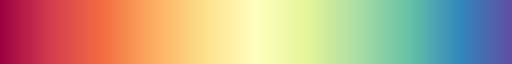

In [31]:
sns.color_palette("Spectral", as_cmap=True)

In [32]:
cmap_g = ListedColormap(sns.color_palette("Spectral", Ng))
cmap_r = ListedColormap(sns.color_palette("Spectral", Nr))
cmap_i = ListedColormap(sns.color_palette("Spectral", Ni))
cmap_z = ListedColormap(sns.color_palette("Spectral", Nz))
cmap_y = ListedColormap(sns.color_palette("Spectral", Ny))
#patch_to_color[patch] = cmap.colors[idx]

In [33]:
all_colors_g = [cmap_g.colors[idx] for idx in range(Ng)]
all_colors_r = [cmap_r.colors[idx] for idx in range(Nr)]
all_colors_i = [cmap_i.colors[idx] for idx in range(Ni)]
all_colors_z = [cmap_z.colors[idx] for idx in range(Nz)]
all_colors_y = [cmap_y.colors[idx] for idx in range(Ny)]

In [34]:
ra_g = ccdvisit_subset_g['ra'].apply(func_degToRad) 
dec_g = ccdvisit_subset_g['dec'].apply(func_degToRad) 

In [35]:
# Galactic plane
gal_long = np.linspace(-180.,180,360)
gal_lat = np.zeros((360))
coordinates_galactic_planes = SkyCoord(l=gal_long*u.degree, b=gal_lat*u.degree, frame='galactic')
gp_radec = coordinates_galactic_planes.transform_to('icrs')  
# for galactic plane
# gp_radec.ra : 0., 360.
# gp_radec.dec : -90, 90
gp_ra_toplot = coordinates.Angle(gp_radec.ra.degree*u.degree)
gp_ra_toplot = gp_ra_toplot.wrap_at(180*u.degree)
# gp_ra_toplot -180, 180
#wrapping angle : https://docs.astropy.org/en/stable/api/astropy.coordinates.Angle.html

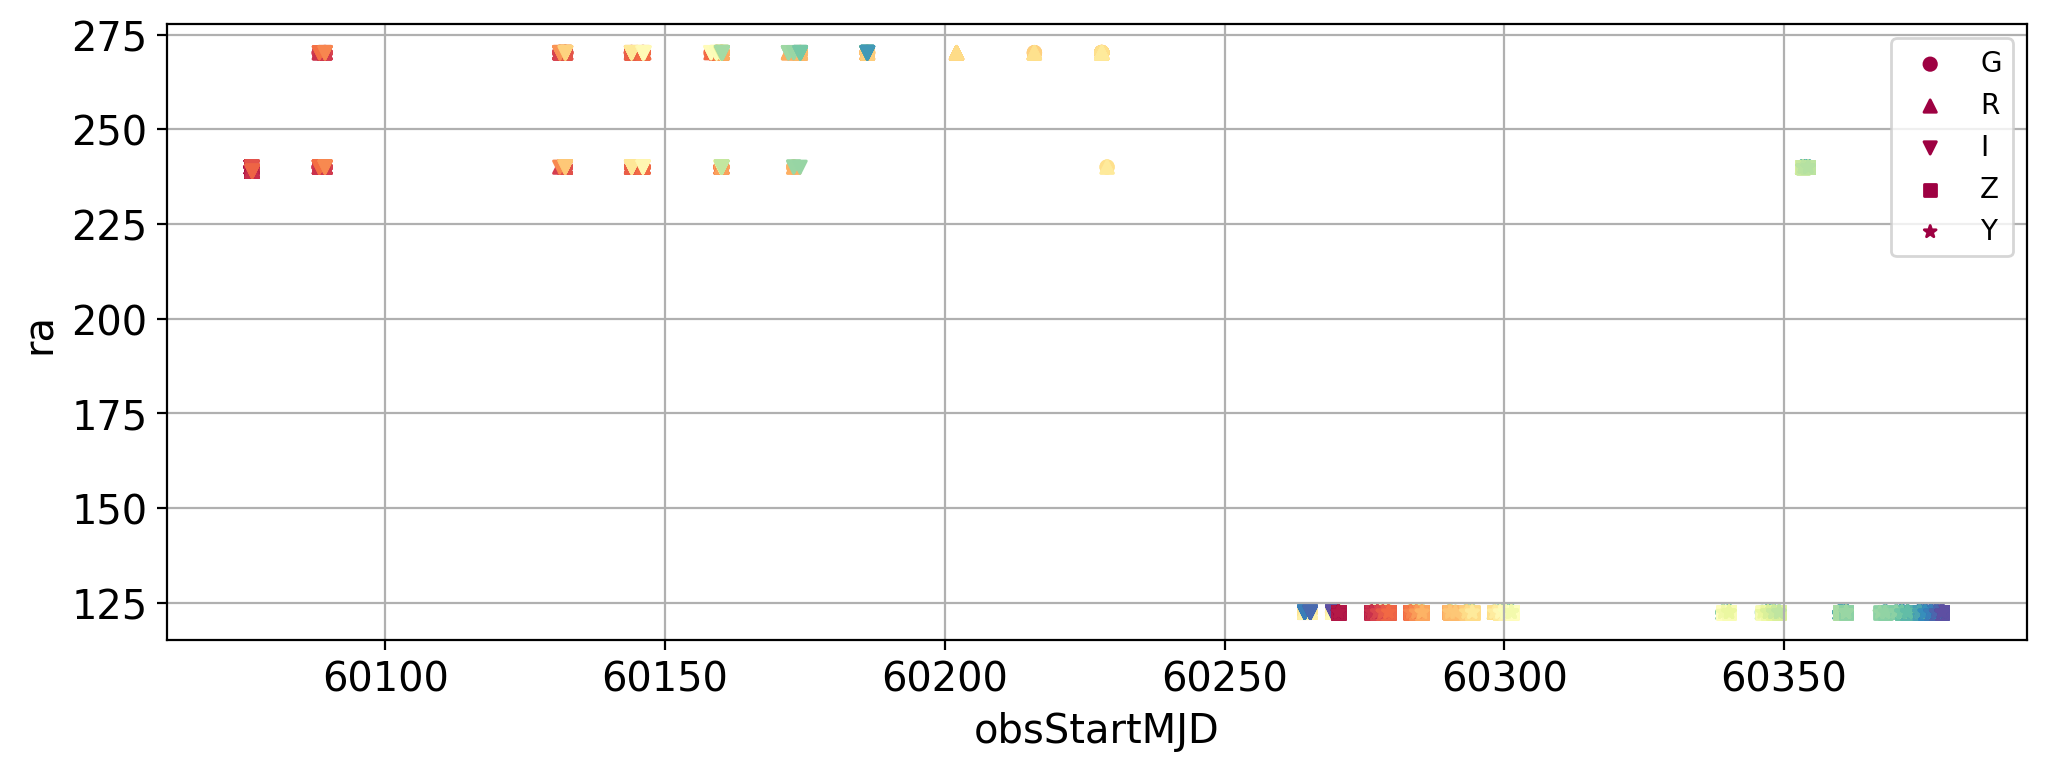

In [36]:
fig,ax = plt.subplots(1,1,figsize=(12,4),dpi=200)
#ax.scatter(ccdvisit_subset_g["obsStartMJD"].values,ccdvisit_subset_g["ra"].values ,c=all_colors_g)
ccdvisit_subset_g.plot.scatter(x="obsStartMJD",y="ra",marker="o",c=all_colors_g,ax=ax,label="G")
ccdvisit_subset_r.plot.scatter(x="obsStartMJD",y="ra",marker="^",c=all_colors_r,ax=ax,label="R")
ccdvisit_subset_i.plot.scatter(x="obsStartMJD",y="ra",marker="v",c=all_colors_i,ax=ax,label="I")
ccdvisit_subset_z.plot.scatter(x="obsStartMJD",y="ra",marker="s",c=all_colors_z,ax=ax,label="Z")
ccdvisit_subset_y.plot.scatter(x="obsStartMJD",y="ra",marker="*",c=all_colors_y,ax=ax,label="Y")
ax.grid()
ax.grid()
ax.grid()

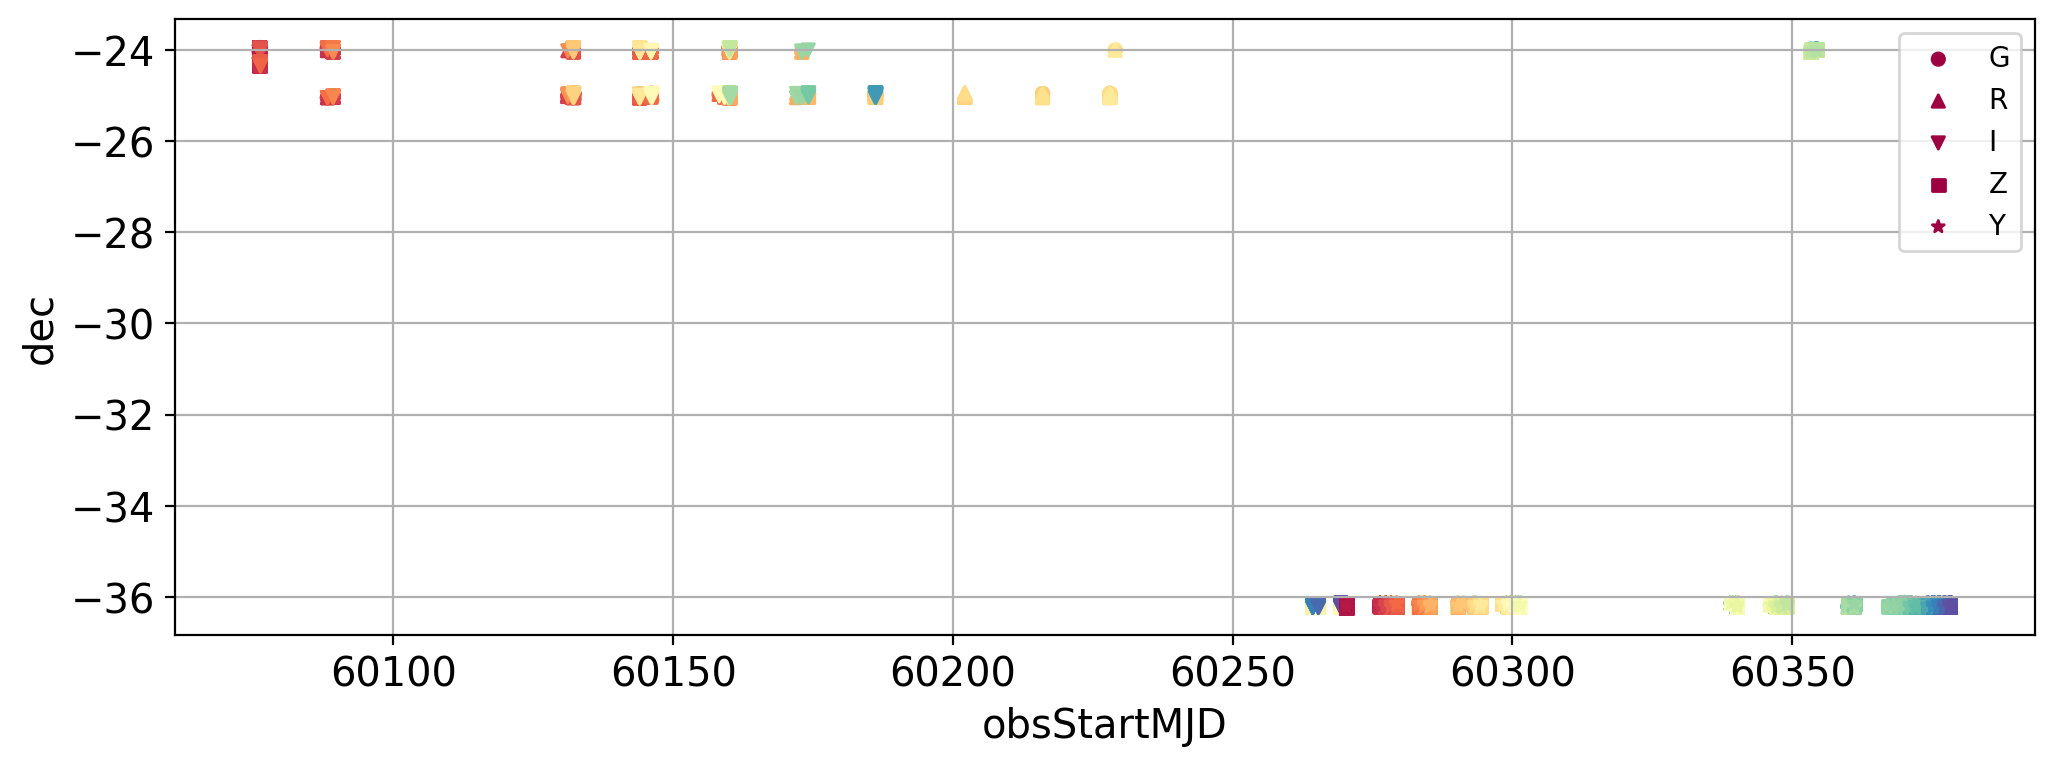

In [37]:
fig,ax = plt.subplots(1,1,figsize=(12,4),dpi=200)
#ax.scatter(ccdvisit_subset_g["obsStartMJD"].values,ccdvisit_subset_g["ra"].values ,c=all_colors_g)
ccdvisit_subset_g.plot.scatter(x="obsStartMJD",y="dec",marker="o",c=all_colors_g,ax=ax,label="G")
ccdvisit_subset_r.plot.scatter(x="obsStartMJD",y="dec",marker="^",c=all_colors_r,ax=ax,label="R")
ccdvisit_subset_i.plot.scatter(x="obsStartMJD",y="dec",marker="v",c=all_colors_i,ax=ax,label="I")
ccdvisit_subset_z.plot.scatter(x="obsStartMJD",y="dec",marker="s",c=all_colors_z,ax=ax,label="Z")
ccdvisit_subset_y.plot.scatter(x="obsStartMJD",y="dec",marker="*",c=all_colors_y,ax=ax,label="Y")
ax.grid()

In [38]:
dict_tract_to_coords_rad

OrderedDict([(3864, {'ra': 2.1369208912742756, 'dec': -0.6361076034128094}),
             (5614, {'ra': 4.160487568267564, 'dec': -0.42839899821678995}),
             (5615, {'ra': 4.1887902047863905, 'dec': -0.42839899821678995}),
             (5634, {'ra': 4.726540298644103, 'dec': -0.42839899821678995})])

Text(0.5, 0.98, 'LATISS')

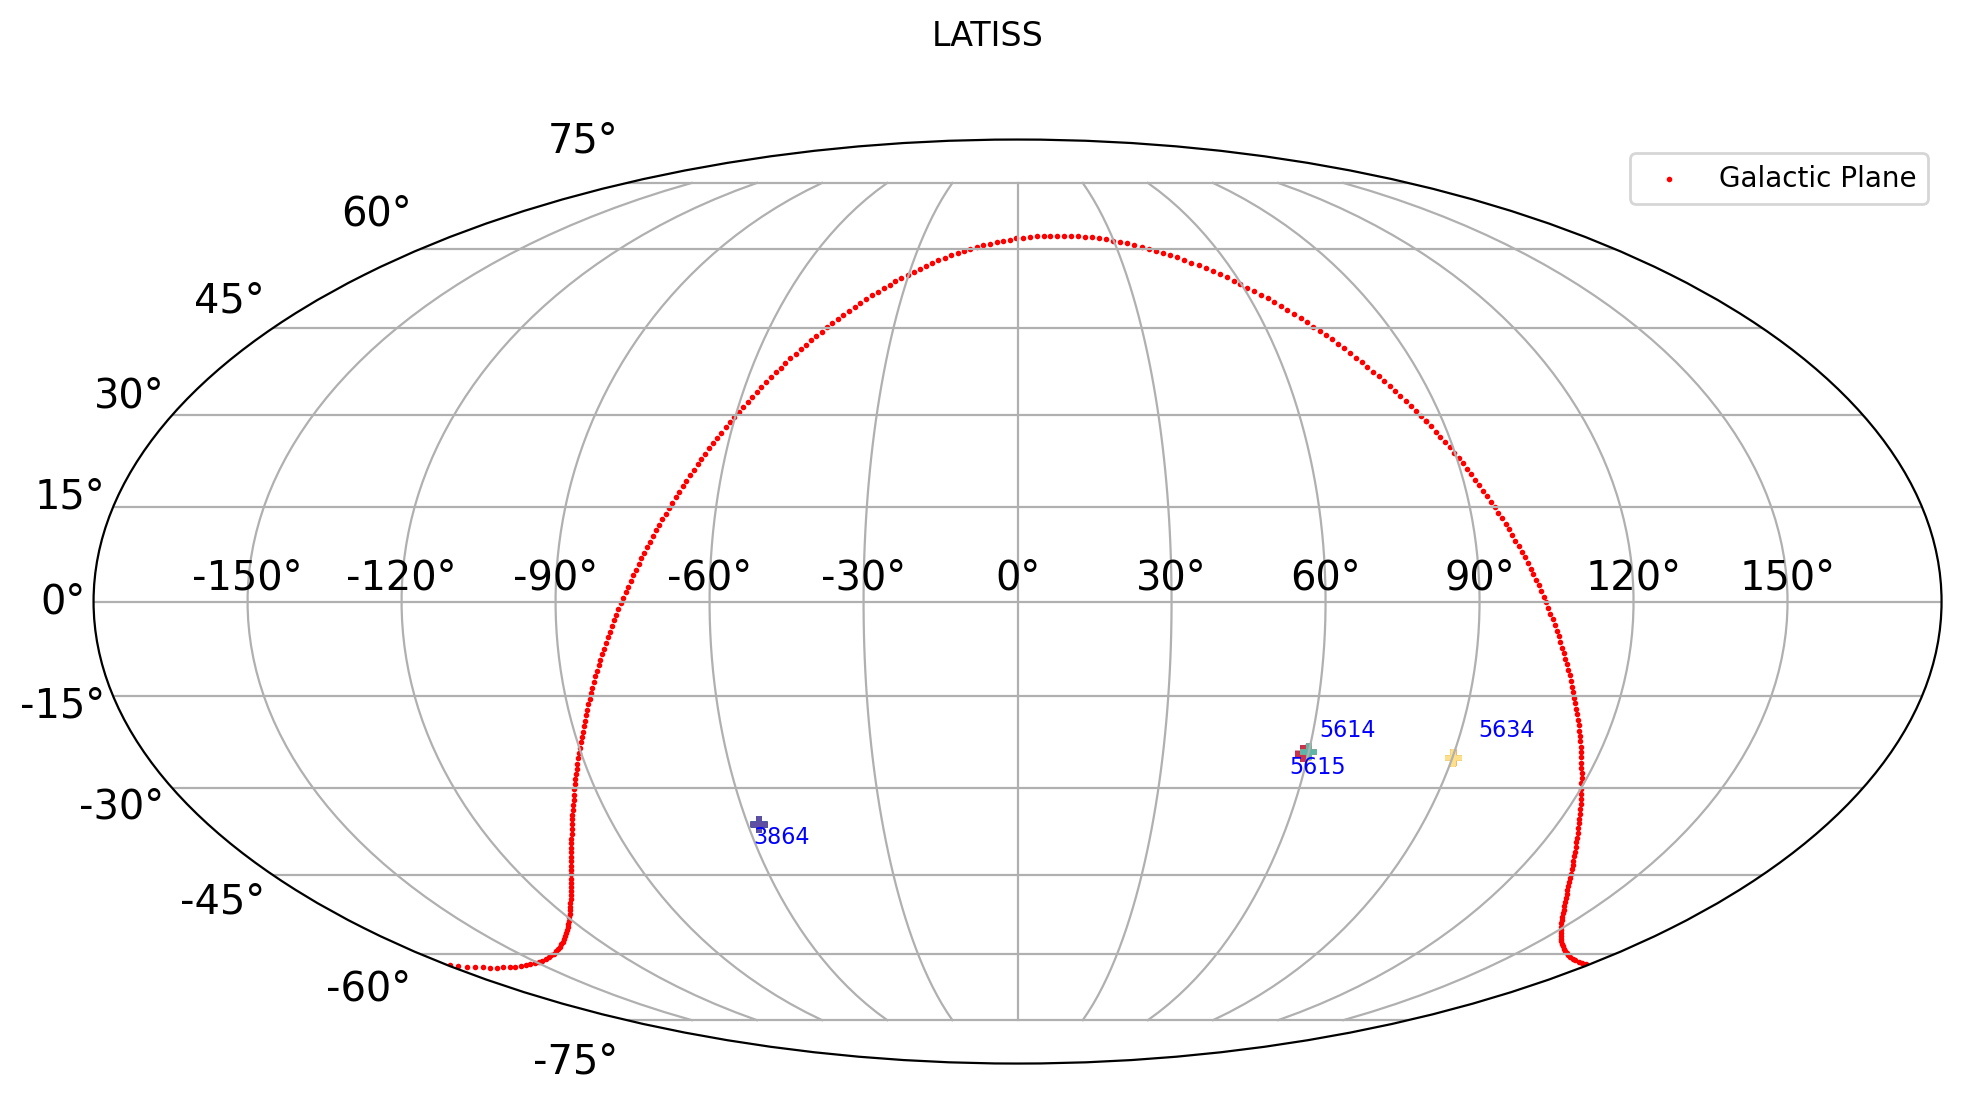

In [39]:
# plot
# x arg in rad must be (-2pi,2pi), y arg in rad  must be in ( -pi,pi )
fig = plt.figure(figsize=(12,6),dpi=200)
#ax = fig.add_subplot(111, projection="aitoff")
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(gp_ra_toplot.radian, gp_radec.dec.radian,c="r",label="Galactic Plane",s=1)
ax.scatter(ra_g.values-np.pi,dec_g.values,marker='+',c=all_colors_g)
ax.legend()
ax.grid()

index=0
for key, value in dict_tract_to_coords_rad.items():
    tract_num_str= str(key)
    x = value["ra"] - np.pi
    y = value["dec"] 
    
    if index%2 == 0:
        dy= -Angle(3,lsst.geom.degrees).asRadians()
        dx= -Angle(3,lsst.geom.degrees).asRadians()
    else:
        dy= Angle(3,lsst.geom.degrees).asRadians()
        dx= Angle(3,lsst.geom.degrees).asRadians()
        
    ax.text(x+dx, y+dy, tract_num_str, fontsize=8,color="b")
    index+=1

plt.suptitle(instrument)

Text(0.5, 0.98, 'LATISS')

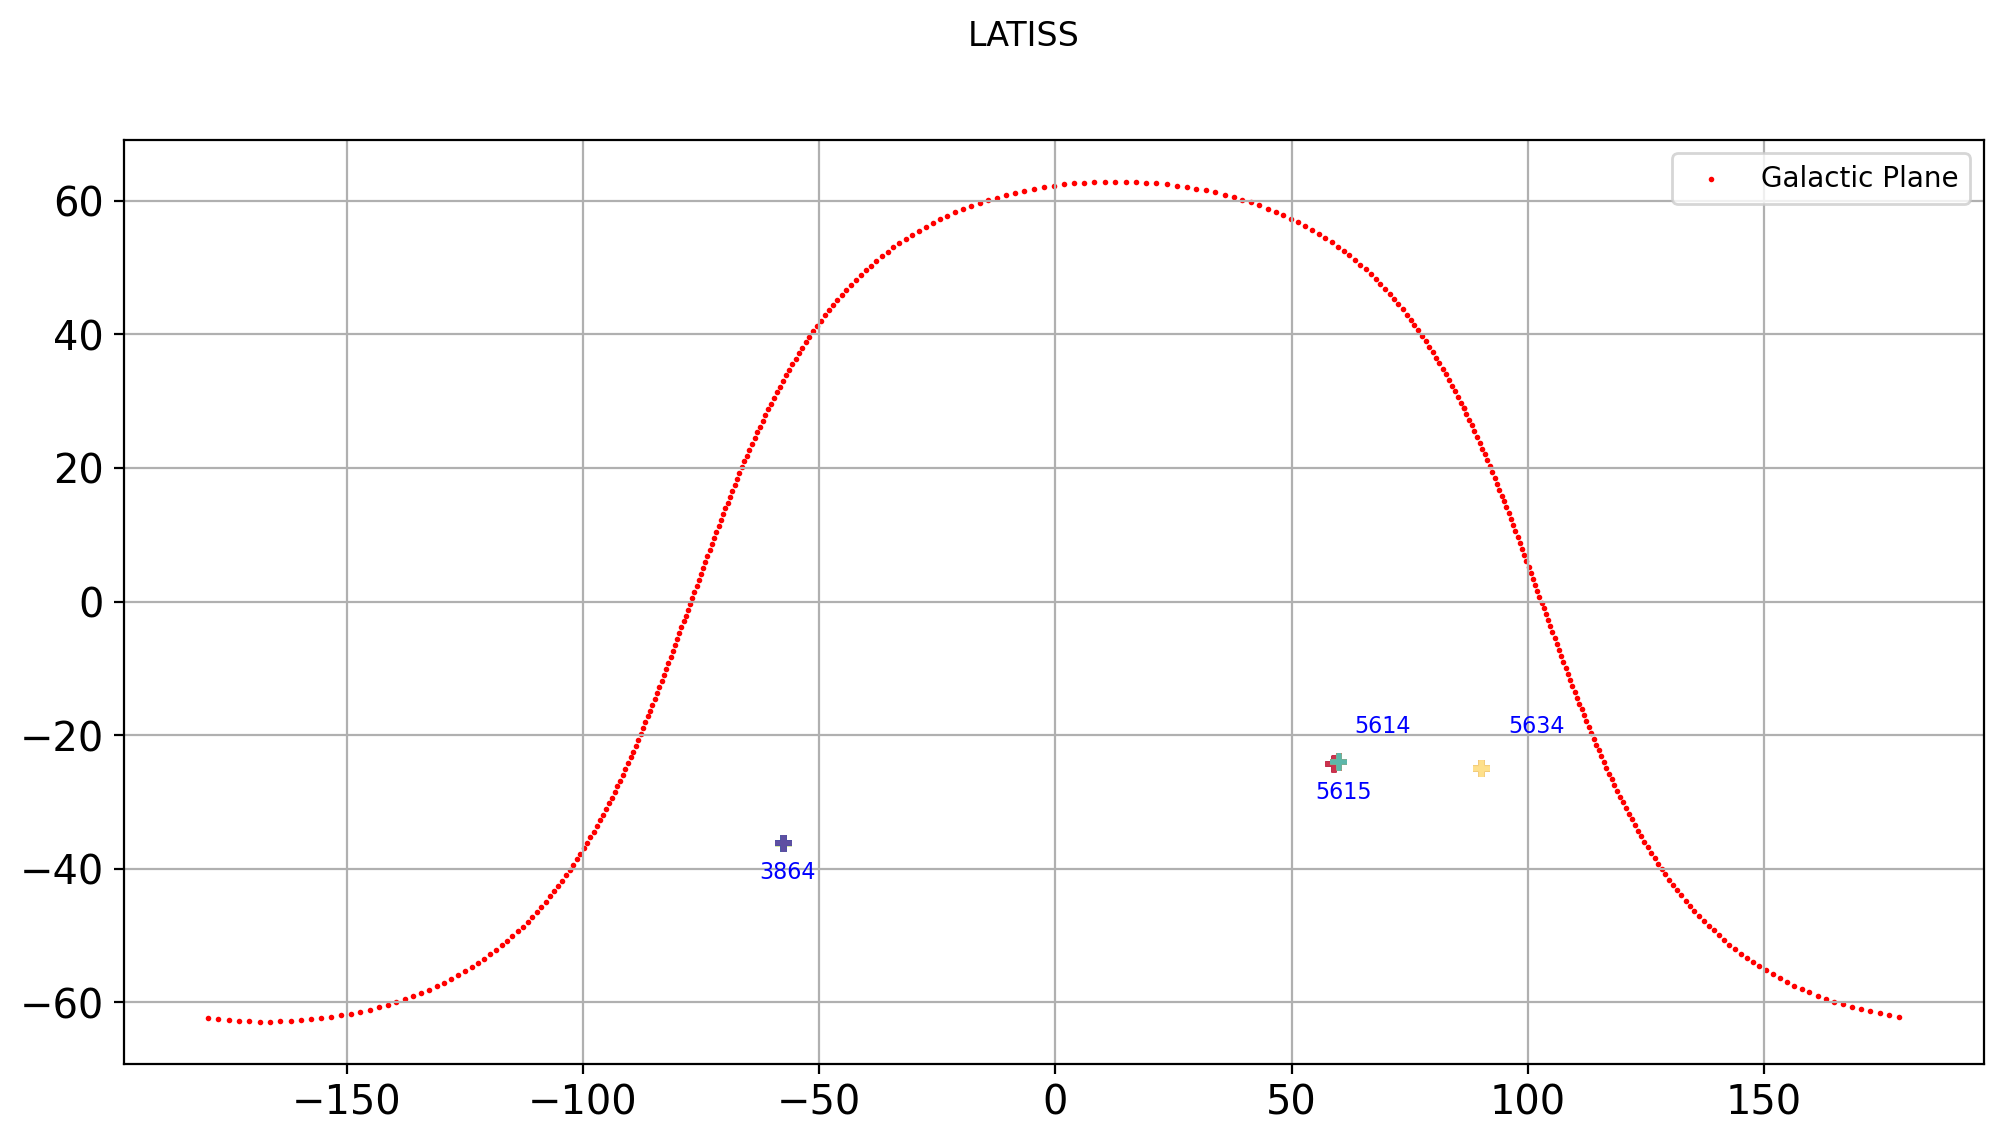

In [40]:
# plot
# x arg in rad must be (-2pi,2pi), y arg in rad  must be in ( -pi,pi )
fig = plt.figure(figsize=(12,6),dpi=200)
#ax = fig.add_subplot(111, projection="aitoff")
ax = fig.add_subplot(111)
ax.scatter(gp_ra_toplot.degree, gp_radec.dec.degree,c="r",label="Galactic Plane",s=1)
ax.scatter(ccdvisit_subset_g['ra'].values -180.,ccdvisit_subset_g['dec'].values,marker='+',c=all_colors_g)
ax.legend()
ax.grid()

index=0
for key, value in dict_tract_to_coords_andvisits.items():
    
    tract_num_str= str(key)
    x = value['ra_deg'].asDegrees() - 180
    y = value["dec_deg"].asDegrees() 
    
    if index%2 == 0:
        dy= -5
        dx= -5
    else:
        dy= 5
        dx= 5
        
    ax.text(x+dx, y+dy, tract_num_str, fontsize=8,color="b")
    index+=1

plt.suptitle(instrument)

## sourceTable_visit

In [41]:
if 0:
    all_data = []
    data_product = 'sourceTable_visit'
    datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= "instrument='LSSTComCamSim'")
    for i, ref in enumerate(datasetRefs):
        if (i % 500 == 0):
            print(f"======================== datasetType = {data_product} ============================================")
            print("fullId..................:",ref.dataId.full)
        try:
            data = butler.get(data_product, dataId=ref.dataId )  
            all_data.append(data)
       
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)       

    df = pd.concat(all_data)
    filename = f"out-{data_product}.csv" 
    df.to_csv(filename)

## How do I access an object table?

In [42]:
objectTable_refs = sorted(butler.registry.queryDatasets('objectTable_tract'))
N = len(objectTable_refs)
objectTable = butler.get(objectTable_refs[0])
objectTable[['coord_ra','coord_dec','tract','patch']]

column,coord_ra,coord_dec,tract,patch
objectId,,,,
1533950662142853121,122.585257,-36.274335,3864,216
1533950662142853122,122.607277,-36.274183,3864,216
1533950662142853123,122.619057,-36.274143,3864,216
1533950662142853124,122.616207,-36.273869,3864,216
1533950662142853125,122.597948,-36.273681,3864,216
...,...,...,...,...
1533973751887039775,122.397264,-36.217165,3864,237
1533973751887039776,122.478993,-36.216272,3864,237
1533973751887039777,122.446877,-36.152160,3864,237


In [43]:
objectTable[['tract','patch']].groupby(["tract","patch"]).size()

tract  patch
3864   216       323
       217      1217
       218      1551
       219       254
       235       775
       236      2363
       237      2370
       238      1004
       254      1595
       255      2556
       256      2349
       257       956
       273       236
       274       436
       275       348
       276       109
dtype: int64

In [44]:
patches = objectTable["patch"].unique()

In [45]:
patches

array([216, 217, 219, 235, 236, 238, 254, 255, 256, 257, 273, 274, 275,
       276, 218, 237])

In [46]:
from collections import OrderedDict
tracts_patchs_dict = OrderedDict()
objectTable_refs = sorted(butler.registry.queryDatasets('objectTable_tract'))
N = len(objectTable_refs)
for idx in range(N):
    objectTable = butler.get(objectTable_refs[idx])
    tract = objectTable["tract"].unique()[0] 
    patches = objectTable["patch"].unique()
    tracts_patchs_dict[tract] = patches 
    del objectTable

In [47]:
tracts_patchs_dict

OrderedDict([(3864,
              array([216, 217, 219, 235, 236, 238, 254, 255, 256, 257, 273, 274, 275,
                     276, 218, 237])),
             (5614,
              array([210, 211, 212, 213, 229, 230, 231, 232, 248, 249, 250, 251])),
             (5615,
              array([274, 275, 276, 293, 294, 295, 312, 313, 314, 331, 332, 333])),
             (5634,
              array([ 52,  54,  55,  71,  72,  73,  74,  90,  91,  92,  93, 109, 110,
                     111, 112,  53]))])

In [48]:
import pickle
# Store data (serialize)
filetractpatch_out = 'lsstcomcamsim_tractspatchs_20240403.pickle'
with open(filetractpatch_out, 'wb') as handle:
    pickle.dump(tracts_patchs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## preSourceTable

In [49]:
if 0:
    all_data = []
    data_product = 'preSourceTable'
    datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= "instrument='LSSTComCamSim'")
    for i, ref in enumerate(datasetRefs):
        if (i % 500 == 0):
            print(f"======================== datasetType = {data_product} ============================================")
            print("fullId..................:",ref.dataId.full)
        try:
            data = butler.get(data_product, dataId=ref.dataId )  
            all_data.append(data)
       
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)       

    df = pd.concat(all_data)
    filename = f"out-{data_product}.csv" 
    df.to_csv(filename)